In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.metrics import mean_median, efficiency_gap, polsby_popper, partisan_gini
from functools import (partial, reduce)
import pandas
import geopandas as gp
import numpy as np
import networkx as nx
import pickle
import seaborn as sns
import pprint
import operator
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
import random
from nltk.util import bigrams
from nltk.probability import FreqDist
from gingleator import Gingleator
from numpy.random import randn
from scipy.stats import norm, probplot

## Set up AR graph and seed plans

In [82]:
## Set up AR
graph_AR = pickle.load(open("graph_AR.p", "rb"))
df_AR = pickle.load(open("df_AR.p", "rb"))

AR_updaters = {"population": updaters.Tally("TOTPOP", alias="population"),
               "bvap": updaters.Tally("BVAP", alias="bvap"),
               "vap": updaters.Tally("VAP", alias="vap"),
               "bvap_prec": lambda part: {k: part["bvap"][k] / part["vap"][k]
                                          for k in part["bvap"]}}

AR_enacted_senate = GeographicPartition(graph_AR, assignment="SSD", updaters=AR_updaters)

In [3]:
total_population_AR = sum(df_AR.TOTPOP.values)
ideal_population_AR = total_population_AR / 35

In [4]:
senate_seed = recursive_tree_part(graph_AR, range(35), pop_col="TOTPOP",
                                pop_target=ideal_population_AR,
                                epsilon=0.01, node_repeats=1)
AR_seed_senate = GeographicPartition(graph_AR, assignment=senate_seed,updaters=AR_updaters)

In [4]:
house_seats = 100
house_seed = recursive_tree_part(graph_AR, range(house_seats), pop_col="TOTPOP",
                                pop_target=total_population_AR / house_seats,
                                epsilon=0.05, node_repeats=1)
AR_seed_house = GeographicPartition(graph_AR, assignment=house_seed,updaters=AR_updaters)

In [83]:
AR_enacted_house = GeographicPartition(graph_AR, assignment="SHD", updaters=AR_updaters)

In [125]:
H_enact = Gingleator.num_opportunity_dists(AR_enacted_house, "bvap_prec", 0.4)
H_seed = Gingleator.num_opportunity_dists(AR_seed_house, "bvap_prec", 0.4)

In [85]:
Gingleator.num_opportunity_dists(AR_enacted_house, "bvap_prec", 0.4)

13

In [8]:
Gingleator.reward_partial_dist(AR_seed_senate, "bvap_prec", 0.4)

3.371373070863733

In [9]:
Gingleator.reward_next_highest_close(AR_seed_senate, "bvap_prec", 0.4)

3.71373070863733

In [5]:
Gingleator.num_opportunity_dists(AR_seed_house, "bvap_prec", 0.4)

10

In [11]:
Gingleator.reward_partial_dist(AR_seed_house, "bvap_prec", 0.4)

10.399854458285176

In [12]:
Gingleator.reward_next_highest_close(AR_seed_house, "bvap_prec", 0.4)

10.99854458285176

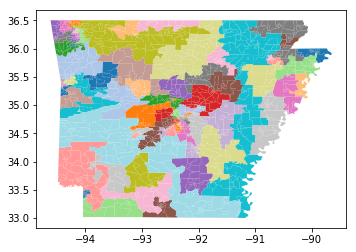

In [17]:
AR_seed_house.plot(df_AR, cmap="tab20")

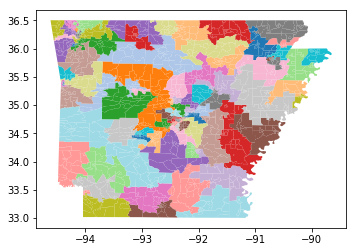

In [21]:
part_unbiased_h[0].plot(df_AR, cmap="tab20")

## AR House Analysis

In [6]:
## Gingleators
AR_house_gingles = Gingleator(AR_seed_house, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                              epsilon=0.1)

In [7]:
AR_house_gingles_rp = Gingleator(AR_seed_house, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                              epsilon=0.1, score_funct=Gingleator.reward_partial_dist)

In [8]:
AR_house_gingles_sp = Gingleator(AR_seed_house, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                              epsilon=0.1, score_funct=Gingleator.reward_next_highest_close)

In [72]:
## Unbiased Observations
_, AR_observations_hub = AR_house_gingles.short_burst_run(num_bursts=1, num_steps=5000)

In [73]:
_, AR_observations_hubr = AR_house_gingles_rp.short_burst_run(num_bursts=1, num_steps=5000)

In [74]:
_, AR_observations_hubsp = AR_house_gingles_sp.short_burst_run(num_bursts=1, num_steps=5000)

In [75]:
## Short Burst Observations
_, AR_observations_hsb = AR_house_gingles.short_burst_run(num_bursts=250, num_steps=25)

In [76]:
_, AR_observations_hsbr = AR_house_gingles_rp.short_burst_run(num_bursts=250, num_steps=25)

In [77]:
_, AR_observations_hsbsp = AR_house_gingles_sp.short_burst_run(num_bursts=250, num_steps=25)

In [141]:
## Tilted Obersvations
_, AR_observations_ht = AR_house_gingles.biased_run(num_iters=5000, p=0.125)

In [142]:
_, AR_observations_htr = AR_house_gingles_rp.biased_run(num_iters=5000, p=0.125)

In [143]:
_, AR_observations_htsp = AR_house_gingles_sp.biased_run(num_iters=5000, p=0.125)

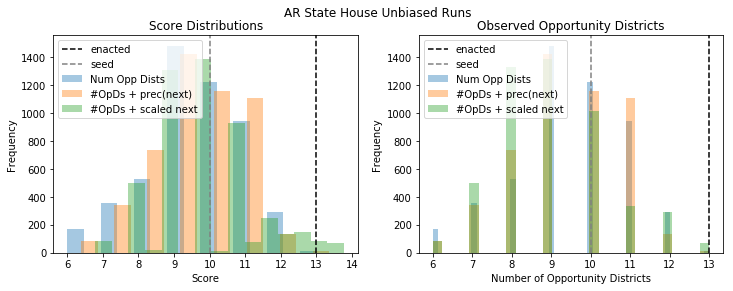

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle("AR State House Unbiased Runs")
ax1.set_title("Score Distributions")
ax1.set_xlabel("Score")
ax1.set_ylabel("Frequency")
ax1.axvline(x=H_enact, color="k", linestyle="--", label="enacted")
ax1.axvline(x=H_seed, color="grey", linestyle="--", label="seed")
sns.distplot(AR_observations_hub.flatten(), ax=ax1,  bins=15, kde=False, 
             label="Num Opp Dists")
sns.distplot(AR_observations_hubr.flatten(), ax=ax1,  bins=15, kde=False, 
             label="#OpDs + prec(next)")
sns.distplot(AR_observations_hubsp.flatten(), ax=ax1,  bins=15, kde=False, 
             label="#OpDs + scaled next")
ax1.legend()

ax2.set_title("Observed Opportunity Districts")
ax2.set_xlabel("Number of Opportunity Districts")
ax2.set_ylabel("Frequency")
ax2.axvline(x=H_enact, color="k", linestyle="--", label="enacted")
ax2.axvline(x=H_seed, color="grey", linestyle="--", label="seed")
sns.distplot(AR_observations_hub.flatten().astype(int), kde=False, 
             label="Num Opp Dists")
sns.distplot(AR_observations_hubr.flatten().astype(int), kde=False, 
             label="#OpDs + prec(next)")
sns.distplot(AR_observations_hubsp.flatten().astype(int), kde=False, 
             label="#OpDs + scaled next")
plt.legend()

plt.show()
# plt.savefig("plots/AR_state_house/AR_state_house_score_functions_unbiased")

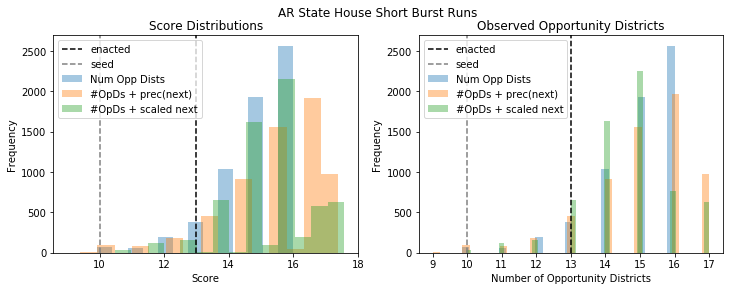

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle("AR State House Short Burst Runs")
ax1.set_title("Score Distributions")
ax1.set_xlabel("Score")
ax1.set_ylabel("Frequency")
ax1.axvline(x=H_enact, color="k", linestyle="--", label="enacted")
ax1.axvline(x=H_seed, color="grey", linestyle="--", label="seed")
sns.distplot(AR_observations_hsb.flatten(), ax=ax1,  bins=15, kde=False, 
             label="Num Opp Dists")
sns.distplot(AR_observations_hsbr.flatten(), ax=ax1,  bins=15, kde=False, 
             label="#OpDs + prec(next)")
sns.distplot(AR_observations_hsbsp.flatten(), ax=ax1,  bins=15, kde=False, 
             label="#OpDs + scaled next")
ax1.legend()

ax2.set_title("Observed Opportunity Districts")
ax2.set_xlabel("Number of Opportunity Districts")
ax2.set_ylabel("Frequency")
ax2.axvline(x=H_enact, color="k", linestyle="--", label="enacted")
ax2.axvline(x=H_seed, color="grey", linestyle="--", label="seed")
sns.distplot(AR_observations_hsb.flatten().astype(int), kde=False, 
             label="Num Opp Dists")
sns.distplot(AR_observations_hsbr.flatten().astype(int), kde=False, 
             label="#OpDs + prec(next)")
sns.distplot(AR_observations_hsbsp.flatten().astype(int), kde=False, 
             label="#OpDs + scaled next")
plt.legend()

plt.show()
# plt.savefig("plots/AR_state_house/AR_state_house_score_functions_short_bursts")

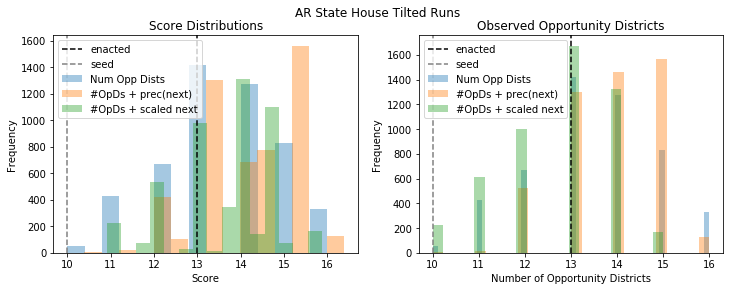

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle("AR State House Tilted Runs")
ax1.set_title("Score Distributions")
ax1.set_xlabel("Score")
ax1.set_ylabel("Frequency")
ax1.axvline(x=H_enact, color="k", linestyle="--", label="enacted")
ax1.axvline(x=H_seed, color="grey", linestyle="--", label="seed")
sns.distplot(AR_observations_ht.flatten(), ax=ax1,  bins=15, kde=False, 
             label="Num Opp Dists")
sns.distplot(AR_observations_htr.flatten(), ax=ax1,  bins=15, kde=False, 
             label="#OpDs + prec(next)")
sns.distplot(AR_observations_htsp.flatten(), ax=ax1,  bins=15, kde=False, 
             label="#OpDs + scaled next")
ax1.legend()

ax2.set_title("Observed Opportunity Districts")
ax2.set_xlabel("Number of Opportunity Districts")
ax2.set_ylabel("Frequency")
ax2.axvline(x=H_enact, color="k", linestyle="--", label="enacted")
ax2.axvline(x=H_seed, color="grey", linestyle="--", label="seed")
sns.distplot(AR_observations_ht.flatten().astype(int), kde=False, 
             label="Num Opp Dists")
sns.distplot(AR_observations_htr.flatten().astype(int), kde=False, 
             label="#OpDs + prec(next)")
sns.distplot(AR_observations_htsp.flatten().astype(int), kde=False, 
             label="#OpDs + scaled next")
plt.legend()

plt.show()
# plt.savefig("plots/AR_state_house/AR_state_house_score_functions_tilted")

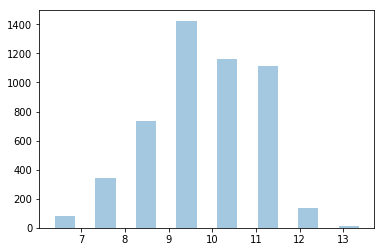

In [81]:
sns.distplot(AR_observations_hubr.flatten(), bins=15, kde=False, label="#OPs + next prec")


## AR Senate Analysis

In [11]:
AR_gingles_partial = Gingleator(AR_seed_senate, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                                epsilon=0.1, score_funct=Gingleator.reward_partial_dist)

In [12]:
AR_gingles_num = Gingleator(AR_seed_senate, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                            epsilon=0.1)

In [8]:
AR_gingles_cont = Gingleator(AR_seed_senate, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                            epsilon=0.1, score_funct=Gingleator.reward_next_highest_close)

In [13]:
_, AR_observations_partial = AR_gingles_partial.short_burst_run(num_bursts=100, num_steps=10)

In [14]:
_, AR_observations_num = AR_gingles_num.short_burst_run(num_bursts=100, num_steps=10)

In [10]:
_, AR_observations_cont = AR_gingles_cont.short_burst_run(num_bursts=100, num_steps=10)

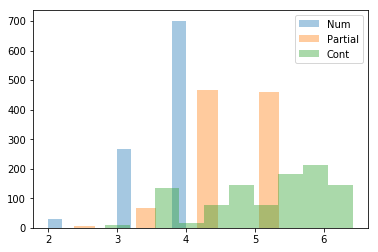

In [17]:
plt.figure()
sns.distplot(AR_observations_num.flatten(), bins=10, kde=False, label="Num")
sns.distplot(AR_observations_partial.flatten(), bins=10, kde=False, label="Partial")
sns.distplot(AR_observations_cont.flatten(), bins=10, kde=False, label="Cont")
plt.legend()
plt.show()

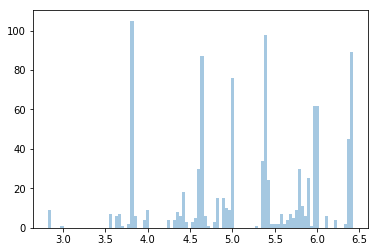

In [21]:
sns.distplot(AR_observations_cont.flatten(), bins=100, kde=False, label="Cont")


In [24]:
AR_observations_cont

array([[3.71373071, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        2.82533371, 2.82533371, 2.82533371, 2.82533371, 2.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.57625611, 3.57625611,
        3.57625611, 3.57625611, 3.57625611, 3.57625611, 3.57625611],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371,
        3.82533371, 3.82533371, 3.82533371, 3.82533371, 3.82533371],
       [3.82533371, 3.82533371, 3.8253337

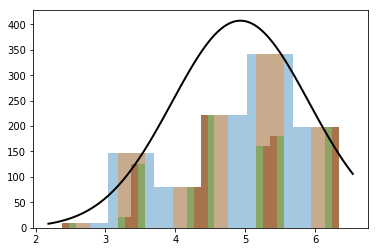

In [42]:
mu, std = norm.fit(AR_observations.flatten())
sns.distplot(AR_observations.flatten(), bins=6, kde=False)
sns.distplot(AR_observations.flatten(), bins=10, kde=False)
sns.distplot(AR_observations.flatten(), bins=20, kde=False)
sns.distplot(AR_observations.flatten(), bins=40, kde=False)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p*1000, 'k', linewidth=2)

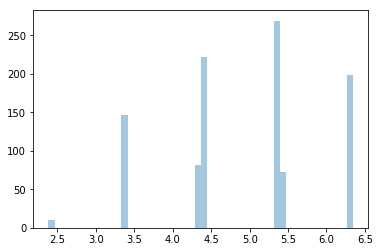

In [45]:
sns.distplot(AR_observations.flatten(), bins=50, kde=False)